![An example image of a bear from the image dataset used in this chapter.](bear.png)

In Chapter 6, we learned to train an image recognition model for multi-label classification. In this notebook, I will apply those concepts to the bear classifier from Chapter 2.

I'll place the prompt of the "Further Research" section here and then answer each part.

> Retrain the bear classifier using multi-label classification. See if you can make it work effectively with images that don't contain any bears, including showing that information in the web application. Try an image with two kinds of bears. Check whether the accuracy on the single-label dataset is impacted using multi-label classification.

Here's a video walkthrough of this notebook:

In [1]:
#| include: false
from IPython.display import HTML

In [3]:
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/cJOtrHtzDSU?start=7193" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

## Setup

In [ ]:
#| include: false
!pip install -Uqq fastai 
!pip install -Uqq fastcore

     |████████████████████████████████| 194kB 18.0MB/s 
     |████████████████████████████████| 776.8MB 23kB/s 
     |████████████████████████████████| 12.8MB 51.7MB/s 
     |████████████████████████████████| 61kB 9.5MB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.1 which is incompatible.


In [ ]:
from fastai.vision.all import *

In [ ]:
import fastai
import pandas as pd

fastai.__version__

'2.3.0'

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


I have three different CSVs with Google Image URLs, one each for black, brown and grizzly bears. The script below, taken from the book, creates a directory for each of the three types of bears in the `bears` folder, and then downloads the corresponding bear type's images into that directory.

In [ ]:
path = Path('/content/gdrive/MyDrive/fastai-course-v4/images/bears')
bear_types = ['black', 'grizzly', 'teddy']
if not path.exists():
  path.mkdir()
  for o in bear_types:
    dest = path/o
    dest.mkdir(exist_ok=True)
    download_images(f'/content/gdrive/MyDrive/fastai-course-v4/images/bears/{o}', url_file=Path(f'/content/gdrive/MyDrive/fastai-course-v4/download_{o}.csv'))

In [ ]:
# confirm that `get_image_files` retrieves all images
fns = get_image_files(path)
fns

(#535) [Path('/content/gdrive/MyDrive/fastai-course-v4/images/bears/black/black_00000002.jpg'),Path('/content/gdrive/MyDrive/fastai-course-v4/images/bears/black/black_00000000.jpg'),Path('/content/gdrive/MyDrive/fastai-course-v4/images/bears/black/black_00000001.jpg'),Path('/content/gdrive/MyDrive/fastai-course-v4/images/bears/black/black_00000003.jpg'),Path('/content/gdrive/MyDrive/fastai-course-v4/images/bears/black/black_00000004.jpg'),Path('/content/gdrive/MyDrive/fastai-course-v4/images/bears/black/black_00000005.jpg'),Path('/content/gdrive/MyDrive/fastai-course-v4/images/bears/black/black_00000007.jpg'),Path('/content/gdrive/MyDrive/fastai-course-v4/images/bears/black/black_00000008.jpg'),Path('/content/gdrive/MyDrive/fastai-course-v4/images/bears/black/black_00000010.jpg'),Path('/content/gdrive/MyDrive/fastai-course-v4/images/bears/black/black_00000009.jpg')...]

In [ ]:
# verify all images
failed = verify_images(fns)
failed

(#0) []

Since I may need to move files around if they are incorrectly labeled, I'm going to prepend the filenames with the corresponding bear type.

In [ ]:
import os
for dir in os.listdir(path):
    for f in os.listdir(path/dir):
      os.rename(path/dir/f, path/dir/f'{dir}_{f}')

In [ ]:
fns = get_image_files(path)
fns

(#723) [Path('/content/gdrive/MyDrive/fastai-course-v4/images/bears/black/black_00000002.jpg'),Path('/content/gdrive/MyDrive/fastai-course-v4/images/bears/black/black_00000000.jpg'),Path('/content/gdrive/MyDrive/fastai-course-v4/images/bears/black/black_00000001.jpg'),Path('/content/gdrive/MyDrive/fastai-course-v4/images/bears/black/black_00000003.jpg'),Path('/content/gdrive/MyDrive/fastai-course-v4/images/bears/black/black_00000004.jpg'),Path('/content/gdrive/MyDrive/fastai-course-v4/images/bears/black/black_00000005.jpg'),Path('/content/gdrive/MyDrive/fastai-course-v4/images/bears/black/black_00000006.jpg'),Path('/content/gdrive/MyDrive/fastai-course-v4/images/bears/black/black_00000007.jpg'),Path('/content/gdrive/MyDrive/fastai-course-v4/images/bears/black/black_00000008.jpg'),Path('/content/gdrive/MyDrive/fastai-course-v4/images/bears/black/black_00000010.jpg')...]

## Single-Label Classifier

I'll train the single-digit classifier as we did in Chapter 2.

In [ ]:
# create DataBlock
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(224, min_scale=0.5))

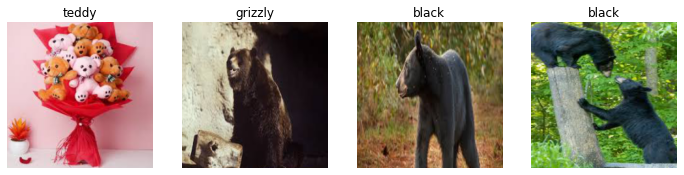

In [ ]:
# create DataLoaders
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

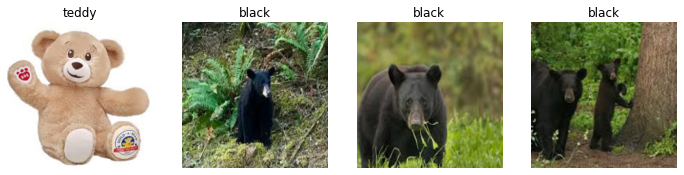

In [ ]:
# verify train batch
dls.train.show_batch(max_n=4, nrows=1)

In [ ]:
# first training
# use it to clean the data
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

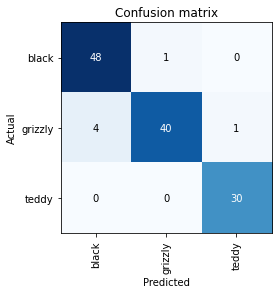

In [ ]:
# view confusion matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

### Initial training: Clean the Dataset

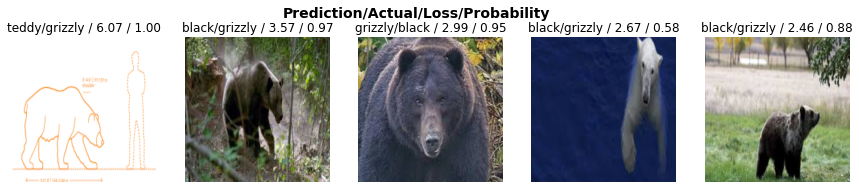

In [ ]:
# plot highest loss images
interp.plot_top_losses(5, nrows=1)

Some of these images are infographics containing text, illustrations and other non-photographic bear data. I'll delete those using the cleaner

In [ ]:
from fastai.vision.widgets import *

In [ ]:
# view highest loss images
# using ImageClassifierCleaner
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
# unlink images with "<Delete>" selected in the cleaner
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

In [ ]:
# move any images reclassified in the cleaner
for idx, cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

After a few rounds of quickly training the model and using the cleaner, I was able to remove or change a couple dozen of the images. I'll use `lr.find()` and re-train the model.

### Second Training with Cleaned Dataset

In [ ]:
path = Path('/content/gdrive/MyDrive/fastai-course-v4/images/bears')

# create DataLoaders
dls = bears.dataloaders(path)

#verify validation batch
dls.valid.show_batch(max_n=4, nrows=1)

In [ ]:
#verify training batch
dls.train.show_batch(max_n=4, nrows=1)

SuggestedLRs(lr_min=0.012022644281387329, lr_steep=0.0005754399462603033)

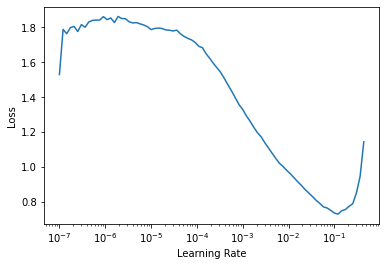

In [ ]:
# find learning rate
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.lr_find()

In [ ]:
# verify loss function
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

In [ ]:
# fit one cycle
lr = 1e-3
learn.fit_one_cycle(5, lr)

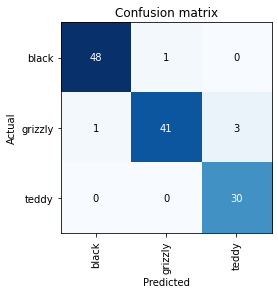

In [ ]:
# view confusion matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

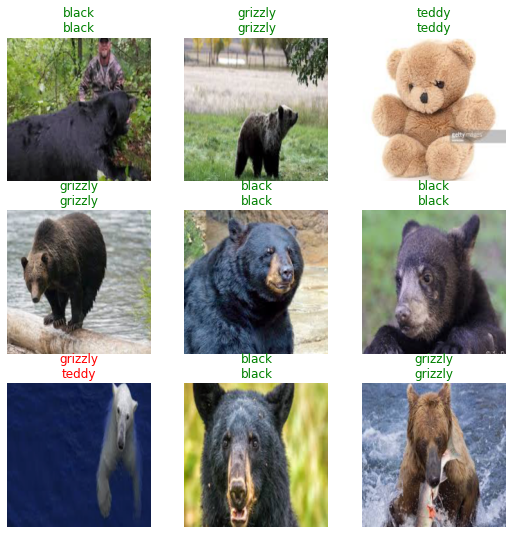

In [ ]:
# show results
learn.show_results()

In [ ]:
#| export the model
learn.export(fname=path/'single_label_bear_classifier.pkl')

## Multi-Label Classifier


There are three major differences between training a multi-label classification model and a single-label model on this dataset. I present them in a table here:

|Classification Model Type|Dependent Variable|Loss Function|`get_y` function|
|:-:|:-:|:-:|:-:|
|Single-label|Decoded string|Cross Entropy (softmax)|`parent_label`|
|Multi-label|One-hot Encoded List|Binary Cross Entropy (sigmoid with threshold)|`[parent_label]`|

In [ ]:
# create helper function
def get_y(o): return [parent_label(o)]

In [ ]:
# create DataBlock
bears = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=get_y,
    item_tfms=RandomResizedCrop(224, min_scale=0.5))

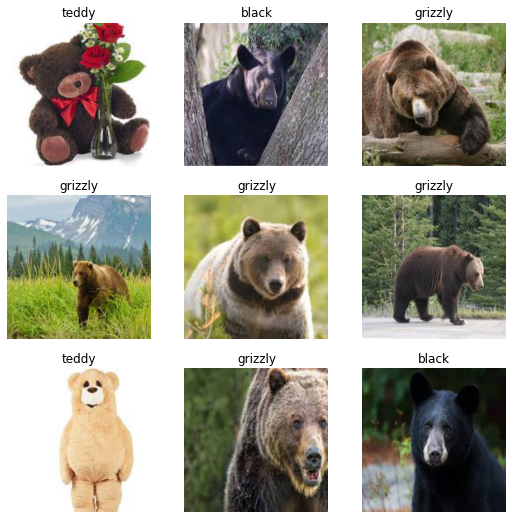

In [ ]:
# view validation batch
dls = bears.dataloaders(path)
dls.show_batch()

In [ ]:
# find learning rate
learn = cnn_learner(dls, resnet18,  metrics=partial(accuracy_multi,thresh=0.95), loss_func=BCEWithLogitsLossFlat(thresh=0.5))
learn.lr_find()

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [ ]:
# verify loss function
learn.loss_func

FlattenedLoss of BCEWithLogitsLoss()

In [ ]:
lr = 2e-2
learn.fit_one_cycle(5, lr)

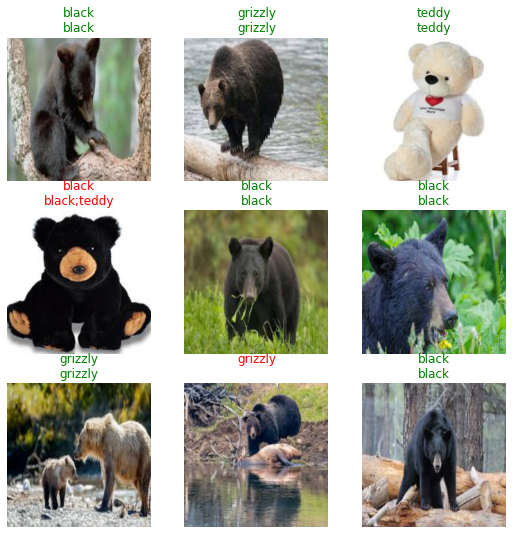

In [ ]:
# verify results
learn.show_results()

In [ ]:
#| export model
learn.export(path/'multi_label_bear_classifier.pkl')

## Model Inference

In [ ]:
path = Path('/content/gdrive/MyDrive/fastai-course-v4/images')

### Image with a Single Bear

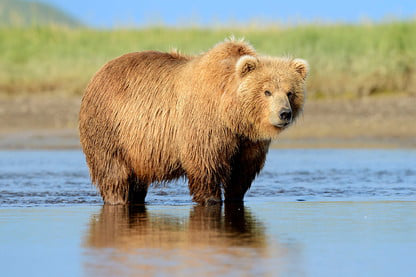

In [ ]:
# grizzly bear image
img = PILImage.create(path/'test'/'grizzly_test_1.jpg')
img

In [ ]:
# load learners
single_learn_inf = load_learner(path/'bears'/'single_label_bear_classifier.pkl')
multi_learn_inf = load_learner(path/'bears'/'multi_label_bear_classifier.pkl')

In [ ]:
# single label classification
single_learn_inf.predict(img)

('teddy', tensor(2), tensor([1.7475e-04, 3.7727e-04, 9.9945e-01]))

In [ ]:
# multi label classification
multi_learn_inf.predict(img)

((#1) ['grizzly'],
 tensor([False,  True, False]),
 tensor([6.3334e-05, 1.0000e+00, 1.4841e-04]))

### Image with Two Bears

In [ ]:
# image with grizzly and black bear
img = PILImage.create(path/'test'/'.jpg')
img

In [ ]:
# single label classification
single_learn_inf.predict(img)

In [ ]:
# multi label classification
multi_learn_inf.predict(img)

In [ ]:
# image with grizzly and teddy bear
img = PILImage.create(path/'test'/'.jpg')
img

In [ ]:
# single label classification
single_learn_inf.predict(img)

In [ ]:
# multi label classification
multi_learn_inf.predict(img)

In [ ]:
# image with black and teddy bear
img = PILImage.create(path/'test'/'.jpg')
img

In [ ]:
# single label classification
single_learn_inf.predict(img)

In [ ]:
# multi label classification
multi_learn_inf.predict(img)

### Images without Bears

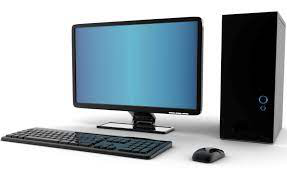

In [ ]:
path = Path('/content/gdrive/MyDrive/fastai-course-v4/images/')
img = PILImage.create(path/'test'/'computer.jpg')
img

In [ ]:
sigle_learn_inf.predict(img)

((#0) [], tensor([False, False, False]), tensor([0.1316, 0.1916, 0.0004]))

In [ ]:
single_learn_inf.predict(img)[2].sum()

tensor(1.)

In [ ]:
# set loss function threshold to 0.9
multi_learn_inf.predict(img)

((#0) [], tensor([False, False, False]), tensor([0.0275, 0.0196, 0.8457]))